# Knowledge Tracing without Time Information

「まず比較対象として１ステップの予測から全てのパスを計算する方法がうまく成立するのか？」を検証するコード

In [1]:
import itertools
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import os

In [2]:
# MPSでサポートしていない演算を実行する際に、CPUにフォールバックするように設定
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

relu = nn.ReLU()

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

# torch.manual_seed(0)

if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

## データ生成法

In [3]:
# 今の状態から次ノードへの遷移確率を計算
# 3-PLモデルを参考
def calculate_transition_probabilities(A, X, guessing=0.2):
    """Aは要素の依存関係を表す行列、Xは状態ベクトル
    """
    n = len(X)
    probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 未習得の要素に関して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 未習得
            probabilities[i] = DINA(A[i, :], X)

    mask = (probabilities != 0)
    non_zero_values = probabilities[mask]

    # 非ゼロ要素にsoftmaxを適用
    normalized_non_zero = softmax(non_zero_values)
    # 結果を元のサイズのテンソルに戻す
    probabilities[mask] = (1-guessing) * normalized_non_zero
    mask2 = (X == 0)
    probabilities[mask2] += guessing / mask2.sum()
    return probabilities

def DINA(Ai, X):
    """共にベクトル
    """
    mask = (Ai != 0) # 0でない要素のみ
    dina = np.min(X[mask] * Ai[mask]) # 全て習得で1
    dina = 1 if dina > 0 else 0
    return dina

def DINO(Ai, X):
    """共にベクトル
    """
    dino = np.sum(X * Ai) # 要素を持つほど大きい
    return dino

def softmax(x):
    exp_x = np.exp(x - np.max(x)) # オーバーフロー対策
    return exp_x / exp_x.sum(axis=0, keepdims=True)

In [4]:
# 人工データ生成
def generate_data(A, num_data_per_step, all_path=False):
    """num_data_per_step: 各ステップで生成するデータ数"""

    n = len(A)-1 # 要素数
    initial_X = np.array([1] + [0] * n) # 初期状態

    dataset = []
    # 各ステップでデータを生成
    for i in range(1, n+1): # 習得数
        for j in range(num_data_per_step):  # 各層の学生数

            X = initial_X.copy()  # 初期状態からスタート
            
            # i問正解させる
            for k in range(i):
                pre_X = X.copy()  # 遷移前の状態
                
                # 確率に基づいて遷移
                probabilities = calculate_transition_probabilities(A, X)
                next_correct_problem = np.random.choice(n+1, p=probabilities)
                X[next_correct_problem] = 1

                # 全ての経路を使う場合
                if all_path:
                    # 差分を教師データとして使用
                    target_Y = (X - pre_X).clip(min=0)  # 新たな習得部分のみを1
                    dataset.append((pre_X.copy(), target_Y.copy()))  # (入力データ, 教師データ)
            
            if not all_path:
                # 最終的な状態を教師データとして使用
                target_Y = (X - initial_X).clip(min=0)
                dataset.append((initial_X.copy(), target_Y.copy()))

    return dataset

## モデル構築

In [5]:
def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [6]:
bcsoftmax1d = BCSoftmax1d.apply

# バッチを処理するとき
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

class Model(nn.Module):
    def __init__(self, num_components):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_components, num_components)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

In [7]:
def train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, hyp, reg):
    model.train()
    data, targets = train_X.to(device), train_Y.to(device)

    losses = []       # 個別損失を記録
    relu = nn.ReLU()

    for i, target in enumerate(targets):
        # 全状態を生成
        states = [(1,) + state for state in itertools.product([0, 1], repeat=num_components)]
        states = sorted(states, key=lambda state: sum(state))

        # 初期化
        initial_state = (1,) + tuple(0 for _ in range(num_components))
        node_probabilities = defaultdict(lambda: torch.tensor(0.0, requires_grad=True, device=device))
        node_probabilities[tuple(initial_state)] = torch.tensor(1.0, requires_grad=True, device=device)

        for state in states:
            state_tensor = torch.tensor(state, dtype=torch.float32, requires_grad=True).to(device)

            if state_tensor.sum().item() == target.sum().item():  # スカラー値として比較
                break

            c = 1 - state_tensor  # budget
            probabilities = model(state_tensor, c)

            for j in range(num_components + 1):
                if state[j] == 0:  # 0 の要素を更新
                    next_state = list(state)
                    next_state[j] = 1
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device)
                    node_probabilities[tuple(next_state)] = (
                        node_probabilities[tuple(next_state)]
                        + probabilities[j] * node_probabilities[tuple(state)]
                    )

        # サンプルの損失を計算
        loss = 1 - node_probabilities[tuple(target.tolist())]
        losses.append(loss)  # サンプルごとの損失を記録

    # 正則化項
    loss_o = torch.stack(losses).mean()  # バッチ全体の平均損失を計算
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o

    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
    return float(loss)


def val_loss(model, num_components, device, val_X, val_Y, criterion, hyp, reg):
    model.eval()
    data, targets = val_X.to(device), val_Y.to(device)

    losses = []       # 個別損失を記録
    relu = nn.ReLU()

    for i, target in enumerate(targets):
        # 全状態を生成
        states = [(1,) + state for state in itertools.product([0, 1], repeat=num_components)]
        states = sorted(states, key=lambda state: sum(state))

        # 初期化
        initial_state = (1,) + tuple(0 for _ in range(num_components))
        node_probabilities = defaultdict(lambda: torch.tensor(0.0, requires_grad=True, device=device))
        node_probabilities[tuple(initial_state)] = torch.tensor(1.0, requires_grad=True, device=device)

        for state in states:
            state_tensor = torch.tensor(state, dtype=torch.float32, requires_grad=True).to(device)

            if state_tensor.sum().item() == target.sum().item():  # スカラー値として比較
                break

            c = 1 - state_tensor  # budget
            probabilities = model(state_tensor, c)

            for j in range(num_components + 1):
                if state[j] == 0:  # 0 の要素を更新
                    next_state = list(state)
                    next_state[j] = 1
                    next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device)
                    node_probabilities[tuple(next_state)] = (
                        node_probabilities[tuple(next_state)]
                        + probabilities[j] * node_probabilities[tuple(state)]
                    )

        # サンプルの損失を計算
        loss = 1 - node_probabilities[tuple(target.tolist())]
        losses.append(loss)  # サンプルごとの損失を記録

    # 正則化項
    loss_o = torch.stack(losses).mean()  # バッチ全体の平均損失を計算
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o
    return float(loss)

def l1(model):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg

def l2(model):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.named_parameters():
        l2_reg = l2_reg + torch.sum(torch.pow(param, 2))
    return l2_reg

In [8]:
# データをトレーニングと検証に分割（正解数のバランスが良くなるように分割）
# 8:2に分割
def split_balanced_data(train_X, train_Y, ratio=0.8):
    data_per_correct_count = defaultdict(list)
    for x, y in zip(train_X, train_Y):
        correct_count = sum(y)
        data_per_correct_count[correct_count].append((x, y))

    train_X_data, train_Y_data, val_X_data, val_Y_data = [], [], [], []
    for correct_count, data in data_per_correct_count.items():
        split_index = int(len(data) * ratio)
        train_data = data[:split_index]
        val_data = data[split_index:]
        train_X_data.extend([x for x, y in train_data])
        train_Y_data.extend([y for x, y in train_data])
        val_X_data.extend([x for x, y in val_data])
        val_Y_data.extend([y for x, y in val_data])

    return train_X_data, train_Y_data, val_X_data, val_Y_data

In [9]:
import argparse

parser = argparse.ArgumentParser()

# 要素（問題）数・依存行列の種類。実験回数
parser.add_argument('--component_size', type=int  , default=5    , help='number of components')
parser.add_argument('--num_paterns'   , type=int  , default=5    , help='number of patterns')
parser.add_argument('--trials'        , type=int  , default=5    , help='number of trials')

# 学習
parser.add_argument('--epochs'        , type=int  , default=1500 , help='number of epochs')
parser.add_argument('--lr'            , type=float, default=0.01 , help='learning rate')
parser.add_argument('--early_stopping', type=int  , default=10   , help='number of epochs for early stopping')

# データ生成
parser.add_argument('--split_ratio'   , type=float, default=0.8  , help='split ratio of training and validation data')
parser.add_argument('--num_stepdata'  , type=int  , default=50   , help='number of data per step')
parser.add_argument('--all_path'      , type=bool , default=False, help='use all path or not')

# 正則化
parser.add_argument('--Regularization', type=str  , default='L1' , help='Regularization, L1 or L2 or None')
parser.add_argument('--hyperparameter', type=float, default=0.001, help='hyperparameter for regularization')



_StoreAction(option_strings=['--hyperparameter'], dest='hyperparameter', nargs=None, const=None, default=0.001, type=<class 'float'>, choices=None, help='hyperparameter for regularization', metavar=None)

In [10]:
# テスト用のダミー引数
args, unknown = parser.parse_known_args()
print('args:', args)

args: Namespace(component_size=5, num_paterns=5, trials=5, epochs=1500, lr=0.01, early_stopping=10, split_ratio=0.8, num_stepdata=50, all_path=False, Regularization='L1', hyperparameter=0.001)


## データ生成

In [11]:
"""やってること
・初期状態から遷移する数を1からn/2の範囲で指定
・各列に着目し、親ノードに繋がるように調整
・何かしらの子ノードを持つように調整
"""
def dependency_matrix(n):
    size = n + 1  # 要素数＋初期状態

    # 下三角行列をランダム生成（対角成分は0にする）
    A = np.tril(np.random.randint(0, 2, (size, size)), k=-1).astype(float)

    # 初期状態からの遷移をいくつ作るか
    init = np.random.randint(1, int(size / 2))
    print(init)
    for i in range(init):
        A[i+1] = 0
        A[i+1, 0] = 1
    for j in range(init, size-1):
        A[j+1, 0] = 0
    
    # 各列いずれかに1が格納されるように調整（下三角行列内で）
    for i in range(size):
        if not A[:, i].any():  # i列がすべて0の場合
            # i+1以降の行で0要素目が1でないものをフィルタリング
            candidates = [row for row in range(i + 1, size) if A[row, 0] != 1]
            if candidates:  # 候補が存在する場合のみ処理
                j = np.random.choice(candidates)  # ランダムに行を選択
                A[j, i] = 1.0
                
    # 各ノードが必ず1つの依存関係を持つように調整
    for i in range(size - 1):  # 最後のノード以外をチェック
        if not A[i, :].any():  # 出次数が0のノードを確認
            if i > 1:  # i = 0 の場合をスキップ
                # ランダムに依存関係を作る
                j = np.random.randint(1, i)  # 1からi-1までの数字から選択
                A[i, j] = 1.0

    # 0でない要素の数で割る処理
    nonzero_counts = np.count_nonzero(A[1:], axis=1, keepdims=True)
    A[1:] = np.where(nonzero_counts != 0, A[1:] / nonzero_counts, 0)

    num_components = len(A)-1  # 要素数
    return A, num_components

# # 依存関係行列
# A = np.array([
#     [0, 0, 0, 0, 0, 0],  # 0番目の要素は無視
#     [1, 0, 0, 0, 0, 0],  # 要素1は状態に依存しない
#     [1, 0, 0, 0, 0, 0],  # 要素2は状態に依存しない
#     [0, 1, 1, 0, 0, 0],  # 要素3は要素1と2に依存
#     [0, 0, 0, 1, 0, 0],  # 要素4は要素3に依存
#     [0, 0, 0, 0, 1, 0]   # 要素5は要素4に依存
# ], dtype = float)*3

# # 0でない要素の数で割る処理
# nonzero_counts = np.count_nonzero(A[1:], axis=1, keepdims=True)
# A[1:] = np.where(nonzero_counts != 0, A[1:] / nonzero_counts, 0)

# num_components = len(A)-1  # 要素数

## 評価指標

### KL Divergence

$$ D_{\text{KL}}(p \| q) = \sum_{i} p(i) \log \frac{p(i)}{q(i)} $$

---

### Hellinger距離

$$ H(p, q) = \frac{1}{\sqrt{2}} \left\| \sqrt{p} - \sqrt{q} \right\|_2 $$

$$ \left\| \sqrt{p} - \sqrt{q} \right\|_2 = \sqrt{\sum_{i} \left( \sqrt{p(i)} - \sqrt{q(i)} \right)^2} $$

---

### Jensen-Shannon Divergence

$$ D_{\text{JS}}(p \| q) = \frac{1}{2} D_{\text{KL}}(p \| m) + \frac{1}{2} D_{\text{KL}}(q \| m) $$

$$ m = \frac{1}{2}(p + q) $$

In [12]:
def kl_divergence(p, q, epsilon=1e-10):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # pとqにスムージングを適用
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    
    # KLダイバージェンスの計算
    return np.sum(p * np.log(p / q))

def hellinger_distance(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    # Hellinger距離の計算式: H(p, q) = (1/√2) * ||√p - √q||_2
    sqrt_p = np.sqrt(p)
    sqrt_q = np.sqrt(q)
    distance = np.sqrt(np.sum((sqrt_p - sqrt_q) ** 2)) / np.sqrt(2)
    return np.mean(distance)

def js_divergence(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    m = 0.5 * (p + q)
    jsd = 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))
    
    # 各サンプルの平均を返す
    return np.mean(jsd)

In [13]:
def evaluate(model, num_components, states, comparison = True):
    model.eval()

    node_probabilities = defaultdict(float)
    start = (1,) + tuple(0 for _ in range(num_components))
    node_probabilities[start] = 1

    KL, HD, JSD = 0, 0, 0
    c_KL, c_HD, c_JSD = 0, 0, 0

    for state in states:
        if state == (1,) * (num_components + 1):  # 最後のノードでは遷移がないのでスキップ
            continue

        probabilities = calculate_transition_probabilities(A, np.array(state))

        # 比較手法
        c_pred = []
        total = 0

        # 最下層から頂点までのノードの分布を順に計算
        for i in range(num_components + 1):
            if state[i] == 0:  # 未習得
                # 遷移後の状態
                next_state = list(state)
                next_state[i] = 1
                next_state = tuple(next_state)
                node_probabilities[next_state] += probabilities[i] * node_probabilities[state]

                c_pred.append(state_counts[next_state])
                total += state_counts[next_state]
            else:
                c_pred.append(0)
        
        # budget
        c_g = torch.ones(num_components+1, dtype=torch.float32)
        c_g = relu(c_g - torch.tensor(state, dtype=torch.float32))

        # 状態とその予測分布
        state_tensor = torch.tensor(state, dtype=torch.float32)
        predicted_values = model(state_tensor, c_g) # 予測値を計算

        # 評価指標の計算
        KL += node_probabilities[state] * kl_divergence(probabilities, predicted_values.detach())
        HD += node_probabilities[state] * hellinger_distance(probabilities, predicted_values.detach())
        JSD += node_probabilities[state] * js_divergence(probabilities, predicted_values.detach())

        
        # 比較手法
        if total > 0:
            c_pred = np.array(c_pred) / total
        
        c_KL += node_probabilities[state] * kl_divergence(probabilities, c_pred)
        c_HD += node_probabilities[state] * hellinger_distance(probabilities, c_pred)
        c_JSD += node_probabilities[state] * js_divergence(probabilities, c_pred)
    
    if comparison:
        # 最終的な値をPythonのfloatにキャストする
        return float(KL), float(HD), float(JSD), float(c_KL), float(c_HD), float(c_JSD)
    else:
        return float(KL), float(HD), float(JSD)


In [14]:
import csv
from datetime import datetime

today = datetime.now().strftime("%Y-%m-%d")

# ファイル名に日付を含める
results_csv = f"2_{today}_{args}.csv"

comparison = True

# 初回にヘッダーを追加する
if comparison:
    header = [
    "Iteration", 
    "KL_提案手法",
    "HD_提案手法",
    "JSD_提案手法",
    "KL_比較手法",
    "HD_比較手法",
    "JSD_比較手法"
]
else:
    header = [
    "Iteration", 
    "KL",
    "HD",
    "JSD"
]

try:
    with open(results_csv, "x", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
except FileExistsError:
    pass  # ファイルが既に存在する場合は何もしない

## 学習

In [15]:
for patern in range(args.num_paterns):
    print(f"Patern: {patern+1}")
    #　依存関係行列の生成
    A, num_components = dependency_matrix(args.component_size)
    print(A)

    for trial in range(args.trials):
        print(f"Trial: {trial+1}")

        # データ生成
        X_init = np.array([1] + [0] * num_components)
        s_data = generate_data(A, args.num_stepdata, args.all_path)
        data_X = [input_data for input_data, _ in s_data]
        data_Y = [target_data for _, target_data in s_data]

        train_X_data, train_Y_data, val_X_data, val_Y_data = split_balanced_data(data_X, data_Y, args.split_ratio)

        # PyTorch テンソルに変換
        train_X = torch.tensor(train_X_data, dtype=torch.float32)
        train_Y = torch.tensor(train_Y_data, dtype=torch.float32)
        val_X = torch.tensor(val_X_data, dtype=torch.float32)
        val_Y = torch.tensor(val_Y_data, dtype=torch.float32)

        "状態定義"
        states = [(1,) + state for state in itertools.product([0, 1], repeat=num_components)]
        states = sorted(states, key=lambda state: sum(state))

        # 状態ごとの学生数をカウント
        state_counts = defaultdict(int)
        for i in range(len(train_X)):
            state_tuple = tuple(map(int, train_X[i] + train_Y[i]))
            state_counts[state_tuple] += 1

        "モデル定義"
        # モデル、損失関数、最適化関数の設定
        model = Model(num_components+1)  # 要素数+初期状態
        criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

        model = model.to(device)

        # ロスの初期化
        best_val_loss = float('inf')
        valid_loss_min = float('inf')
        early_stopping_count = 0

        # 試行ごとのロス値を記録するリスト
        training_losses = []
        validation_losses = []
        
        for epoch in range(args.epochs):
            train_loss = train(model, num_components, device, train_X, train_Y, criterion, optimizer, epoch, args.hyperparameter, args.Regularization)
            valid_loss = val_loss(model, num_components, device, val_X, val_Y, criterion, args.hyperparameter, args.Regularization)
            valid_loss_min = min(valid_loss_min, valid_loss)
            
            training_losses.append(train_loss)
            validation_losses.append(valid_loss)

            if valid_loss_min < valid_loss:
                early_stopping_count += 1
            else:
                early_stopping_count = 0
                # torch.save(model.state_dict(), f"{args}_{lr}_{traial}.pth")
                
            if early_stopping_count >= args.early_stopping:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Best validation loss: {valid_loss_min}")

        eval_results = evaluate(model, num_components, states, comparison)
        # 試行ごとの指標をCSVに追記
        with open(results_csv, "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                trial + 1,
                *eval_results
            ])

Patern: 1
2
[[0.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.5        0.         0.5        0.         0.        ]
 [0.         0.33333333 0.33333333 0.         0.33333333 0.        ]]
Trial: 1


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_25626/235124017.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_X = torch.tensor(train_X_data, dtype=torch.float32)


Early stopping at epoch 30
Best validation loss: 1.0033270120620728
Trial: 2
Early stopping at epoch 37
Best validation loss: 1.0030814409255981
Trial: 3
Early stopping at epoch 36
Best validation loss: 1.0030194520950317
Trial: 4


KeyboardInterrupt: 

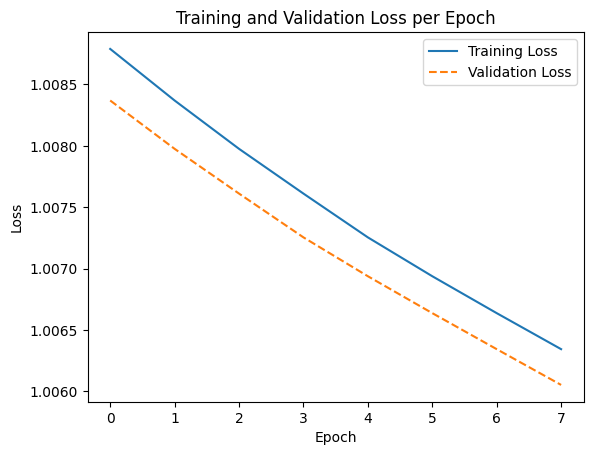

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 図示

tensor([0., 1., 1., 1., 1., 1.])
tensor([[1., 0., 0., 0., 0., 0.]])
tensor(0.)
State: (1, 0, 0, 0, 0, 0), Probabilities: [0.   0.44 0.44 0.04 0.04 0.04], Predicted Values: tensor([0.0000, 0.1649, 0.1456, 0.1891, 0.2048, 0.2956],
       grad_fn=<BCSoftmax1dBackward>)
tensor([0., 1., 1., 1., 1., 0.])
tensor([[1., 0., 0., 0., 0., 1.]])
tensor(0.)
State: (1, 0, 0, 0, 0, 1), Probabilities: [0.   0.45 0.45 0.05 0.05 0.  ], Predicted Values: tensor([0.0000, 0.2769, 0.2356, 0.2433, 0.2443, 0.0000],
       grad_fn=<BCSoftmax1dBackward>)
tensor([0., 1., 1., 1., 0., 1.])
tensor([[1., 0., 0., 0., 1., 0.]])
tensor(0.)
State: (1, 0, 0, 0, 1, 0), Probabilities: [0.   0.45 0.45 0.05 0.   0.05], Predicted Values: tensor([0.0000, 0.2468, 0.1788, 0.2159, 0.0000, 0.3586],
       grad_fn=<BCSoftmax1dBackward>)
tensor([0., 1., 1., 0., 1., 1.])
tensor([[1., 0., 0., 1., 0., 0.]])
tensor(0.)
State: (1, 0, 0, 1, 0, 0), Probabilities: [0.   0.45 0.45 0.   0.05 0.05], Predicted Values: tensor([0.0000, 0.2434, 0.1

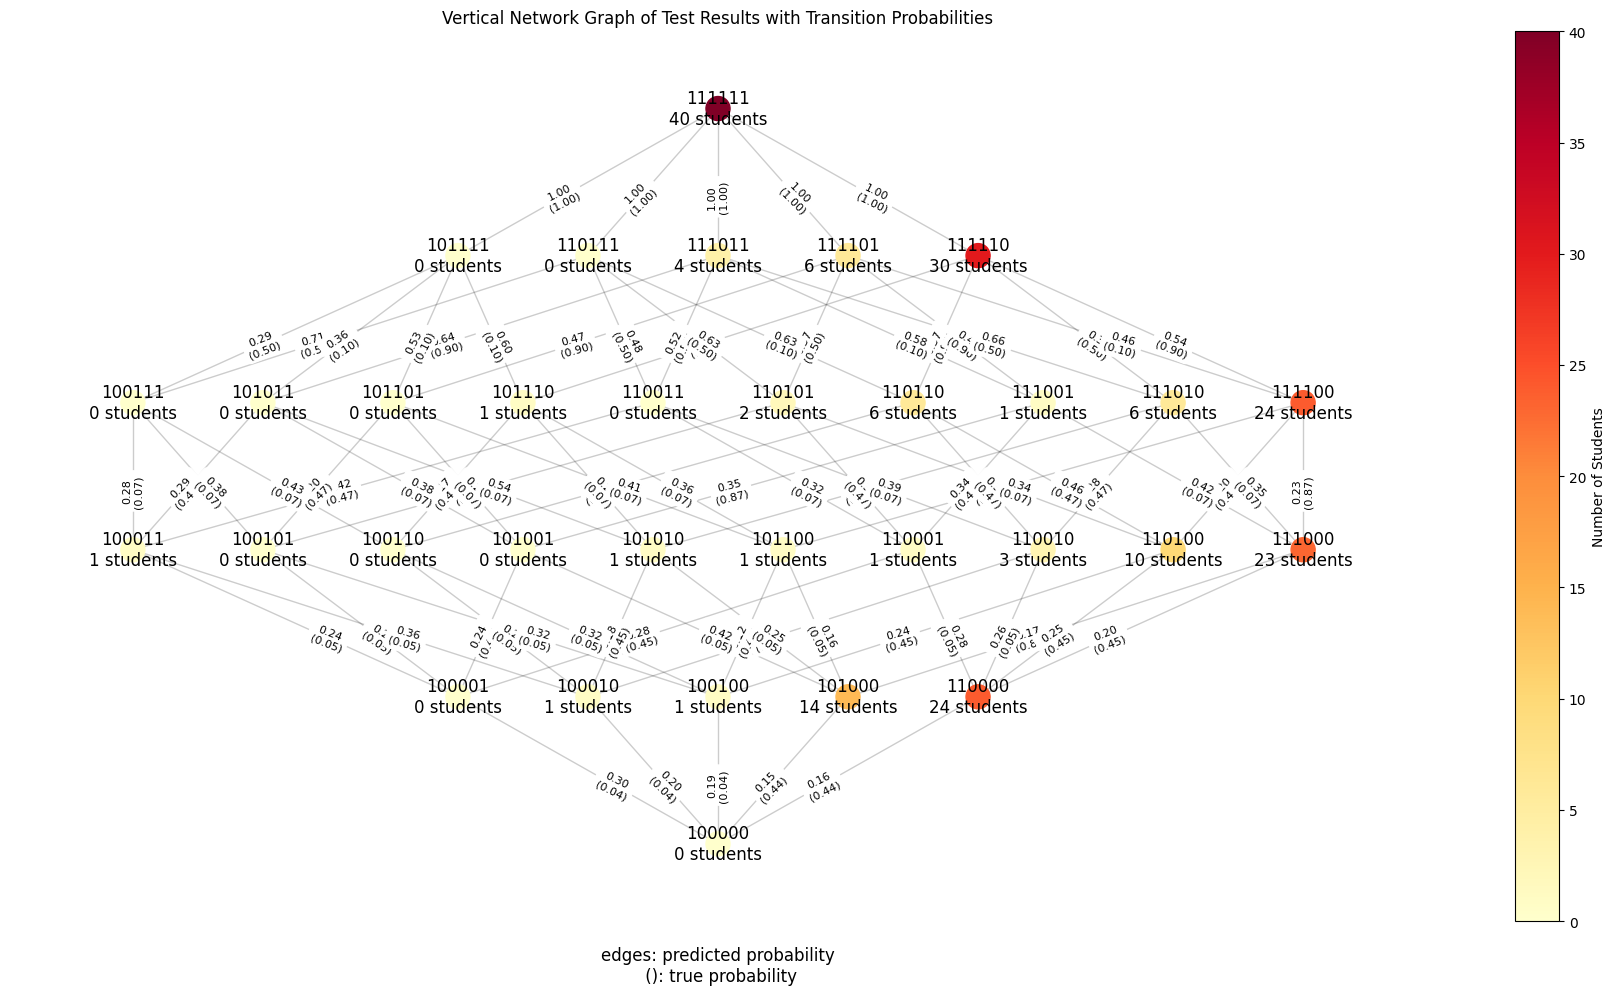

State counts:
State 100000: 0 students
State 110000: 24 students
State 101000: 14 students
State 100010: 1 students
State 100100: 1 students
State 100001: 0 students
State 111000: 23 students
State 110100: 10 students
State 110010: 3 students
State 100011: 1 students
State 101100: 1 students
State 101010: 1 students
State 110001: 1 students
State 100101: 0 students
State 100110: 0 students
State 101001: 0 students
State 110110: 6 students
State 111010: 6 students
State 111001: 1 students
State 111100: 24 students
State 110101: 2 students
State 101110: 1 students
State 100111: 0 students
State 101011: 0 students
State 101101: 0 students
State 110011: 0 students
State 111110: 30 students
State 111101: 6 students
State 111011: 4 students
State 101111: 0 students
State 110111: 0 students
State 111111: 40 students


In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_components+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_components):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_components)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    if state == (1,) * (num_components + 1):  # 最後のノードでは遷移がないのでスキップ
        continue
    
    probabilities = calculate_transition_probabilities(A, np.array(state))
    c_g = torch.ones(num_components+1, dtype=torch.float32)
    c_g = c_g - torch.tensor(state, dtype=torch.float32)  # 予算を更新
    print(c_g)
    print(torch.tensor([state], dtype=torch.float32))
    state_tensor = torch.tensor(state, dtype=torch.float32)
    print(state_tensor[1])
    predicted_values = model(state_tensor, c_g)  # 予測値を計算
    print(f"State: {state}, Probabilities: {probabilities}, Predicted Values: {predicted_values}")

    for i in range(num_components+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                transition_probability = f"({probabilities[i]:.2f})"
                predicted_value = f"{predicted_values[i]:.2f}"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{predicted_value}\n{transition_probability}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
plt.text(
    0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
    "edges: predicted probability\n (): true probability",  # 表示したいテキスト
    horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
    verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
    transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
    fontsize=12,                    # フォントサイズ
    color="black"                   # テキストの色
)

plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")